In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 15, 6
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/brettnaul/miniconda3/envs/deep/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
%run period.py 64 4 0.25 --model_type atrous --sigma 0.5 --sim_type period/uneven/noise0.5 --uneven --no_train --lr 5e-4 --filter_length 5 --batch_norm
train = np.arange(args.N_train)
test = args.N_train + np.arange(args.N_test)
pred_gru = model.predict(X)

[]
/Users/brettnaul/Dropbox/Documents/timeflow/keras2_logs/period/uneven/noise0.5/atrous_064_x4_5m04_drop25_bn_f5
Loading /Users/brettnaul/Dropbox/Documents/timeflow/keras2_logs/period/uneven/noise0.5/atrous_064_x4_5m04_drop25_bn_f5/weights.h5...


In [13]:
%%time
from gatspy.periodic import LombScargleFast

pred_gat = np.zeros(pred_gru.shape)
for i in train[:100]:
    if args.even:
        t = np.linspace(0, 2 * np.pi, args.n_max)
        x = X[i][:, 0]
    else:
        t = np.cumsum(X[i, :, 0])
        x = X[i, :, 1]
    opt_args = {'period_range': (0.05, 0.95 * (t.max() - t.min())), 'quiet': True}
    model_gat = LombScargleFast(fit_period=True, optimizer_kwds=opt_args)#, silence_warnings=True)
    model_gat.fit(t, x)
    omega = 2 * np.pi / model_gat.best_period
    off, A2, A1 = model_gat._best_params(omega)
#    pred_gat[i] = np.array([model_gat.best_period, np.sqrt(A1 ** 2 + A2 ** 2), np.arctan2(A2, A1), off + model_gat.ymean_])
    pred_gat[i] = np.array([model_gat.best_period, A1, A2, off + model_gat.ymean_])

CPU times: user 888 ms, sys: 7.26 ms, total: 895 ms
Wall time: 901 ms


In [15]:
i = -1

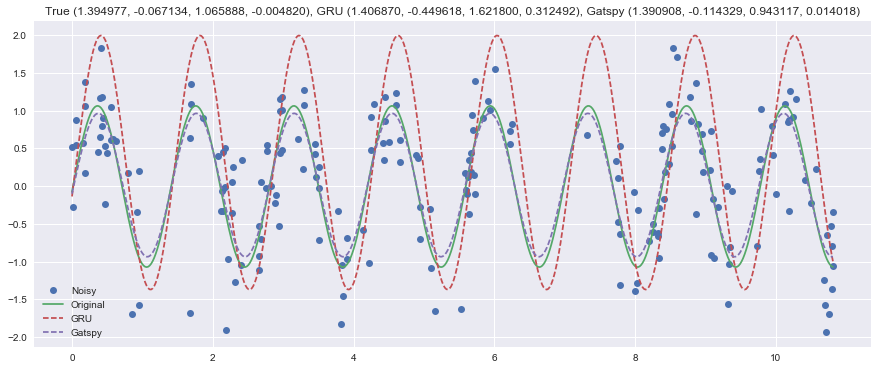

In [21]:
i += 1
if args.even:
    t = np.linspace(0, 2 * np.pi, args.n_max)
    x = X[i].ravel()
else:
    t = X[i, :, 0].cumsum()
    x = X[i, :, 1]
plt.plot(t, x, 'o')

T = np.linspace(0, t.max(), 501)
def sinusoid(p, A1, A2, b):
    return lambda t: A1 * np.cos(2 * np.pi / p * t) + A2 * np.sin(2 * np.pi / p * t) + b

original = sinusoid(*Y[i])
plt.plot(T, original(T), '-')

#p_c, A_c, phi_c, b_c = pred_conv[i]
#x_c = A_c * np.sin(2 * np.pi / p_c * t + phi_c) + b_c
#plt.plot(t, x_c, '--')

rnn = sinusoid(*pred_gru[i])
plt.plot(T, rnn(T), '--')

#omega = 2 * np.pi / model_gat.best_period
#off, A1, A2 = model_gat._best_params(omega)
#w_g, A_g, phi_g, b_g = [omega / 2 / np.pi, np.sqrt(A1 ** 2 + A2 ** 2), np.arctan2(A2, A1), off + model_gat.ymean_]
gat = sinusoid(*pred_gat[i])
plt.plot(T, gat(T), '--')

#plt.legend(['Noisy', 'Original', 'Convolutional', 'GRU', 'Gatspy'])
#plt.title("True ({:3f}, {:3f}, {:3f}, {:3f}), Conv ({:3f}, {:3f}, {:3f}, {:3f}), GRU ({:3f}, {:3f}, {:3f}, {:3f}), Gatspy ({:3f}, {:3f}, {:3f}, {:3f})".format(
#    p, A, phi, b,
#    p_c, A_c, phi_c, b_c,
#    p_r, A_r, phi_r, b_r,
#    p_g, A_g, phi_g, b_g,
#    ))
plt.legend(['Noisy', 'Original', 'GRU', 'Gatspy'])
plt.title("True ({:3f}, {:3f}, {:3f}, {:3f}), GRU ({:3f}, {:3f}, {:3f}, {:3f}), Gatspy ({:3f}, {:3f}, {:3f}, {:3f})".format(
    *Y[i],
    *pred_gru[i],
    *pred_gat[i]
    ));

In [ ]:
sns.jointplot(pred_gru[:, 0] - Y[:, 0], pred_gat[:, 0] - Y[:, 0], kind='hex', xlim=(-.5, .5), ylim=(-.5, .5))
plt.title("GRU MSE: {}\nGatspy MSE: {}".format(np.mean((pred_gru[:, 0] - Y[:, 0]) ** 2), np.mean((pred_gat[:, 0] - Y[:, 0]) ** 2)))
#plt.title("GRU MAE: {}\nGatspy MAE: {}".format(np.median(np.abs(pred_gru[:, 0] - Y[:, 0])), np.median(np.abs(pred_gat[:, 0] - Y[test, 0]))))
sns.jointplot(pred_gru[:, 0], Y[:, 0], kind='hex')
sns.jointplot(pred_gat[:, 0], Y[:, 0], kind='hex')